# Sommaire

>[Sommaire](#scrollTo=OXXSgYy9BBec)

>[Imports et paramètres généraux](#scrollTo=zC7YhIrj59gy)

>[Création des modèles à entraîner](#scrollTo=gZFVwEW96EaG)

>[Fonctions d'affichages et d'enregistrements](#scrollTo=m_Wx43PK6pdE)

>[Entraînement](#scrollTo=5CAxdPTM6wkq)

>[Téléchargements](#scrollTo=4QJiqfKLBU_W)



# Imports et paramètres généraux

Imports des librairies principales et réglage des paramètres d'aléa

In [43]:
!pip install tqdm

# gestions relatives aux fichiers de manière générale
import os

# choix de tensorflow comme backend de Keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# opérations matricielles
import numpy as np

from tqdm import tqdm

# affichages
import matplotlib.pyplot as plt

# les différentes parties utilisées de Keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Convolution2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

# on fixe le seed du random de numpy pour avoir des résultats reproductibles
np.random.seed(1000)

# On choisit la taille du vecteur aléatoire d'entrée du GAN
# 10 marche bien pour MNIST d'après la littérature
randomDim = 10

Chargement du dataset

In [0]:
# Chargement directement depuis Keras
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalisation des données
X_train = (X_train.astype(np.float32) - 127.5)/127.5

# Mise en forme des données d'entraînement
X_train = X_train.reshape(60000, 784)

# Nombre de GANs souhaités
nb_GAN = 20

# Création des modèles à entraîner

Configuration du Générateur

In [0]:
# Une liste contenant les nb_GAN générateurs

generator = []
for i in range(nb_GAN) :
  generator.append(Sequential())
  generator[i].add(Dense(256, input_dim=randomDim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  generator[i].add(LeakyReLU(0.2))
  generator[i].add(Dense(512))
  generator[i].add(LeakyReLU(0.2))
  generator[i].add(Dense(1024))
  generator[i].add(LeakyReLU(0.2))
  generator[i].add(Dense(784, activation='tanh'))
  generator[i].compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))


Configuration du Discriminateur

In [0]:
# Une liste contenant les nb_GAN discriminateurs

discriminator = []
for i in range(nb_GAN) :
  discriminator.append(Sequential())
  discriminator[i].add(Dense(1024, input_dim=784, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
  discriminator[i].add(LeakyReLU(0.2))
  discriminator[i].add(Dropout(0.3))
  discriminator[i].add(Dense(512))
  discriminator[i].add(LeakyReLU(0.2))
  discriminator[i].add(Dropout(0.3))
  discriminator[i].add(Dense(256))
  discriminator[i].add(LeakyReLU(0.2))
  discriminator[i].add(Dropout(0.3))
  discriminator[i].add(Dense(1, activation='sigmoid'))
  discriminator[i].compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

Configuration du GAN comme assemblage du Générateur et du Discriminateur

In [0]:
ganInput = []
x = []
ganOutput = []
gan = []

for i in range(nb_GAN) :

  discriminator[i].trainable = False
  ganInput.append(Input(shape=(randomDim,)))
  x.append(generator[i](ganInput[i]))
  ganOutput.append(discriminator[i](x[i]))
  gan.append(Model(inputs=ganInput[i], outputs=ganOutput[i]))
  gan[i].compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))

# Fonctions d'affichages et d'enregistrements

In [0]:
# Affichage de la fonction de coût du GAN i
def plotLoss(epoch,i):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses[i], label='Discriminitive loss %d' % i)
    plt.plot(gLosses[i], label='Generative loss %d' % i)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('gan_loss_%d_epoch_%d.png' % (i,epoch))

# Affichage d'une mosaïque d'images générées par le Générateur j
def plotGeneratedImages(epoch, j, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, randomDim])
    generatedImages = generator[j].predict(noise)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image_%d_epoch_%d.png' %(j,epoch))

In [0]:
# sauvegarde du réseau de neurones i
def saveModels(epoch,i):
    generator[i].save('gan_generator_%d_epoch_%d.h5' % (i,epoch))
    discriminator[i].save('gan_discriminator_%d_epoch_%d.h5' %(i,epoch))

# Entraînement


  1%|          | 3/468 [00:00<00:17, 27.04it/s]

Epochs: 10
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------



 12%|█▏        | 57/468 [00:02<00:16, 25.23it/s]Exception KeyError: KeyError(<weakref at 0x7f9b31885db8; to 'tqdm' at 0x7f9b3196f350>,) in <object repr() failed> ignored

 22%|██▏       | 105/468 [00:04<00:14, 25.85it/s]


 45%|████▍     | 210/468 [00:08<00:10, 25.70it/s]


 67%|██████▋   | 315/468 [00:12<00:06, 25.44it/s]


 90%|████████▉ | 420/468 [00:16<00:01, 25.09it/s]


  1%|          | 3/468 [00:00<00:19, 23.41it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:15, 29.39it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:17, 26.46it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:19, 23.90it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:18, 24.87it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:20, 23.05it/s]

--------------- Epoch 7 ---------------


  0%|          | 2/468 [00:00<00:24, 19.32it/s]

--------------- Epoch 8 ---------------


  0%|          | 2/468 [00:00<00:24, 19.28it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:22, 20.60it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:17, 26.76it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:16, 28.69it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:17, 26.26it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:17, 26.24it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:18, 25.24it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:17, 25.87it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:18, 24.49it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:16, 27.55it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:16, 28.65it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:18, 25.22it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:19, 23.97it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:18, 25.30it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:17, 26.42it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:17, 26.03it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:17, 27.31it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:18, 24.98it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:18, 25.07it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:17, 27.33it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:18, 25.65it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:21, 22.05it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:17, 26.93it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:18, 25.05it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:21, 21.20it/s]

--------------- Epoch 6 ---------------


  0%|          | 2/468 [00:00<00:24, 19.15it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:18, 24.86it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:20, 22.96it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:18, 24.57it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:19, 23.44it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:18, 24.74it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:17, 27.25it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:18, 25.36it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:18, 25.80it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:16, 28.00it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:22, 20.64it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:17, 26.78it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:17, 27.06it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:17, 26.30it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:16, 27.86it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:22, 21.12it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:19, 24.35it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:17, 26.53it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:17, 27.28it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:17, 27.05it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:18, 24.76it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:18, 24.97it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:16, 27.70it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:17, 27.23it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:17, 26.31it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:16, 28.34it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:17, 26.30it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:17, 26.28it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:18, 25.61it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:19, 24.39it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:18, 25.19it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:17, 25.93it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:18, 25.29it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:18, 25.33it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:17, 27.16it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:17, 25.99it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:16, 28.04it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:15, 29.28it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:17, 25.89it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:16, 28.27it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:17, 27.02it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:18, 25.54it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:16, 28.46it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:17, 27.01it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:17, 26.58it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:18, 24.53it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:18, 24.71it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:18, 25.71it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:18, 24.64it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:16, 28.21it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:17, 27.12it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:18, 25.66it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:17, 26.14it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:17, 27.13it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:18, 24.93it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:18, 25.62it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:18, 24.79it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:17, 26.67it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:33<00:00, 14.02it/s]
/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  1%|          | 3/468 [00:00<00:17, 26.34it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:19, 23.98it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:21, 21.21it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:21, 21.89it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:21, 21.75it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:22, 20.65it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:20, 23.00it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:20, 22.49it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:21, 21.83it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:16, 27.98it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:22, 20.87it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:21, 22.10it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:19, 24.34it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:22, 20.35it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:20, 22.35it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:21, 21.51it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:21, 21.24it/s]

--------------- Epoch 9 ---------------


  0%|          | 2/468 [00:00<00:23, 19.71it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:19, 23.87it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:21, 21.76it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:20, 22.84it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:20, 22.72it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:19, 23.45it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:20, 22.24it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:23, 20.14it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:21, 22.09it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:18, 24.90it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:18, 25.66it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:17, 26.60it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:18, 25.23it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:22, 20.30it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:18, 25.71it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:18, 24.80it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:17, 26.03it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:18, 25.05it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:18, 24.97it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:16, 27.60it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:17, 27.17it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:17, 26.28it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:21, 21.44it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:17, 27.33it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:18, 25.83it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:18, 25.16it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:17, 26.40it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:17, 26.88it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:19, 24.35it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:19, 24.13it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:16, 27.40it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:16, 27.43it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:18, 25.65it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:21, 22.08it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:17, 26.53it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:17, 26.39it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:19, 24.21it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:17, 27.09it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:17, 26.53it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:18, 24.57it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:18, 25.71it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:17, 26.17it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:18, 24.97it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:19, 24.11it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:16, 27.42it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:17, 25.93it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:16, 27.55it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:17, 26.71it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:18, 25.33it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:18, 25.12it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:17, 26.38it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:18, 25.00it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:17, 26.62it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:18, 25.64it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:17, 26.01it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:17, 26.51it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:17, 26.81it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:17, 26.40it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:20, 22.68it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:16, 27.40it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:19, 23.84it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:18, 25.82it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:17, 26.52it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:17, 26.07it/s]

--------------- Epoch 10 ---------------


  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


  1%|          | 3/468 [00:00<00:17, 27.12it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:18, 25.70it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:18, 25.63it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:19, 24.47it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:18, 24.98it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:18, 24.49it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:19, 23.65it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:16, 28.71it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:19, 24.39it/s]

--------------- Epoch 10 ---------------


100%|██████████| 468/468 [00:18<00:00, 25.76it/s]


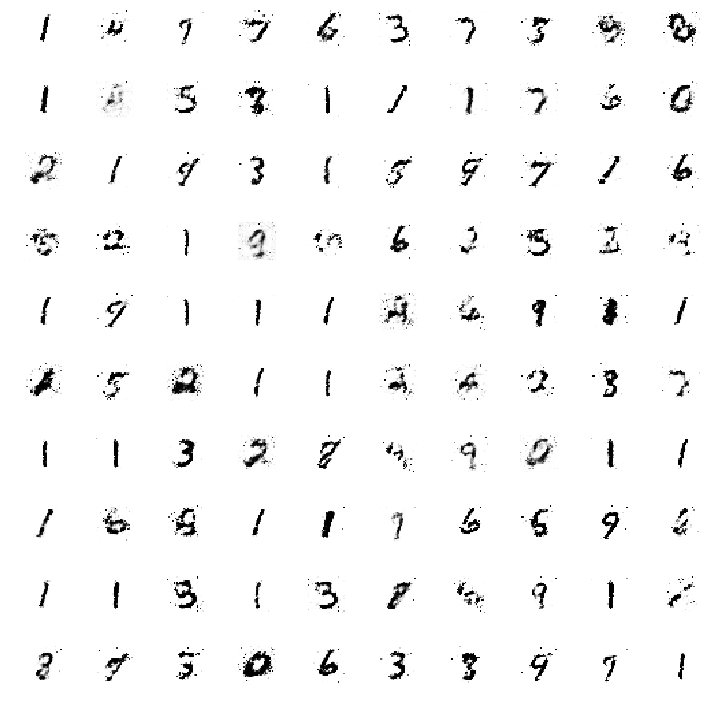

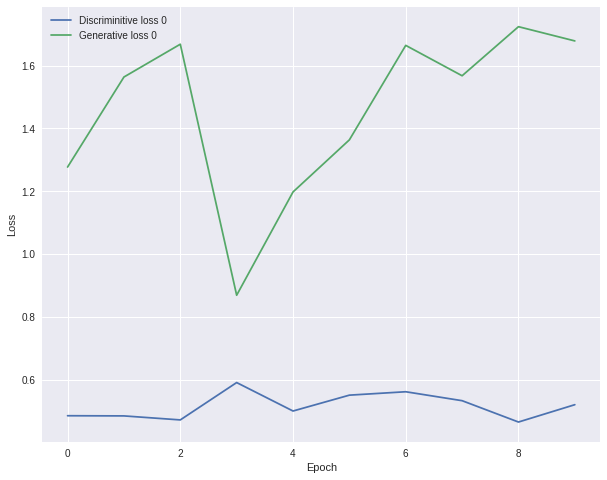

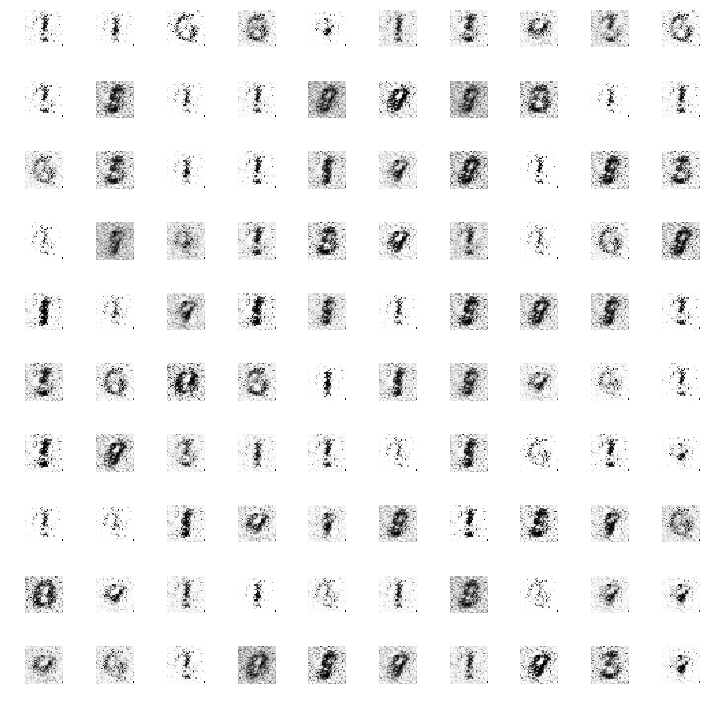

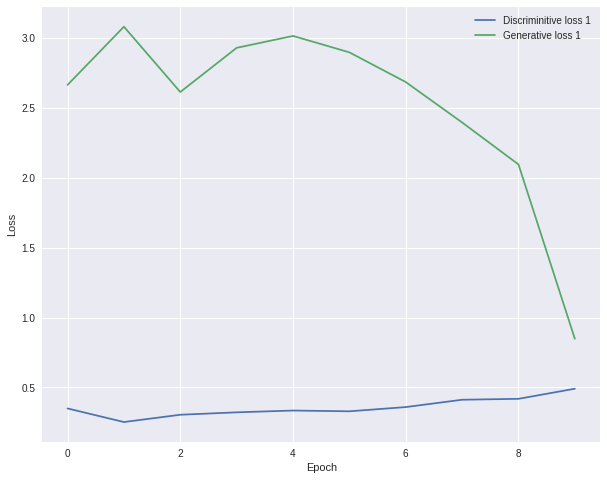

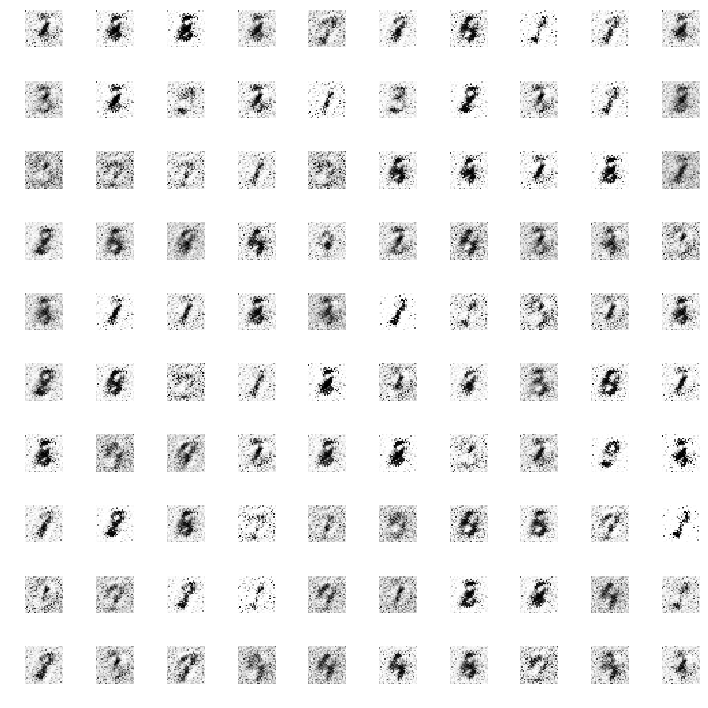

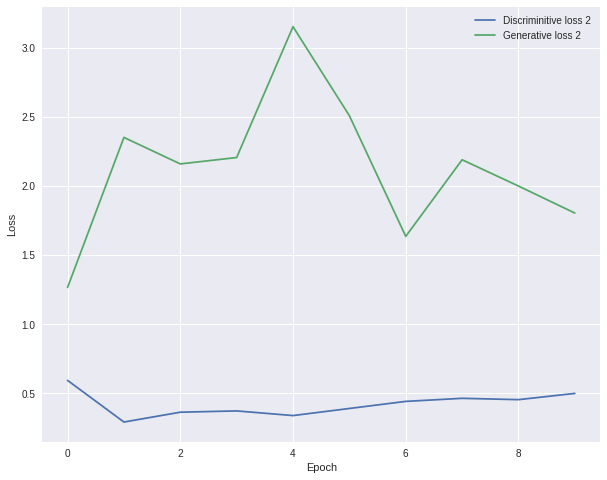

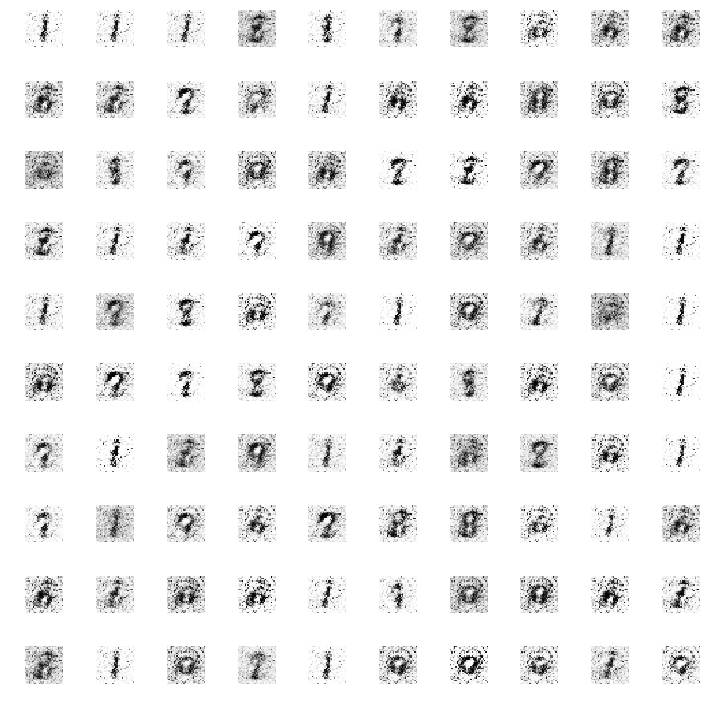

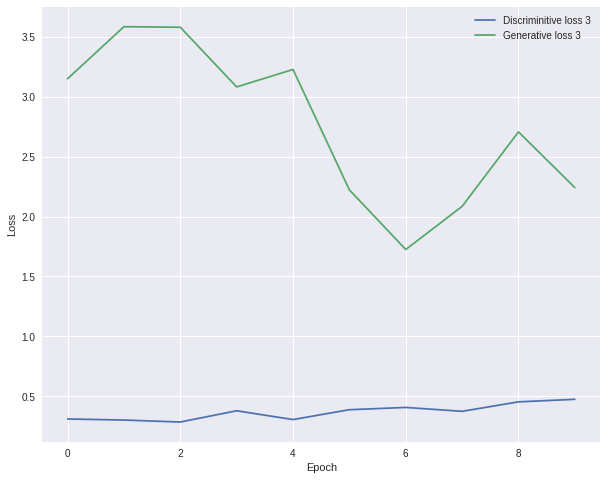

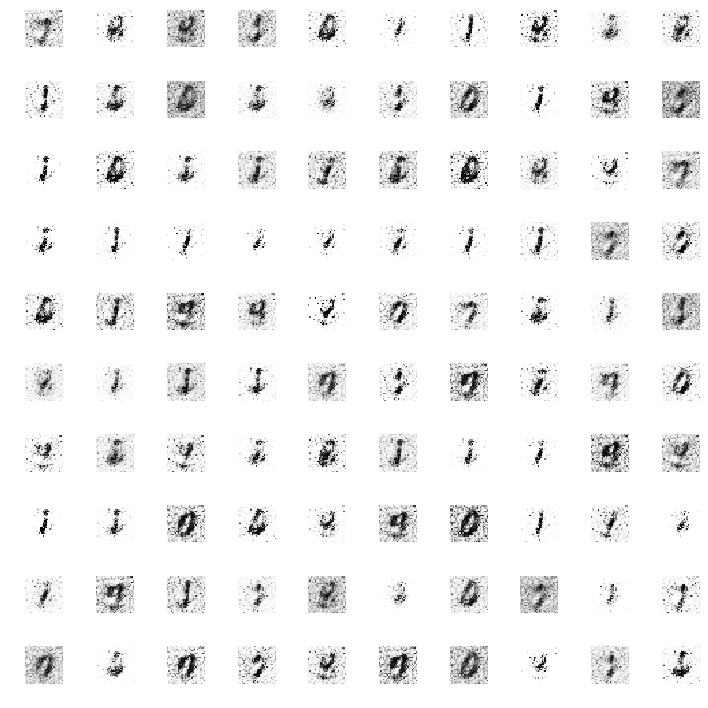

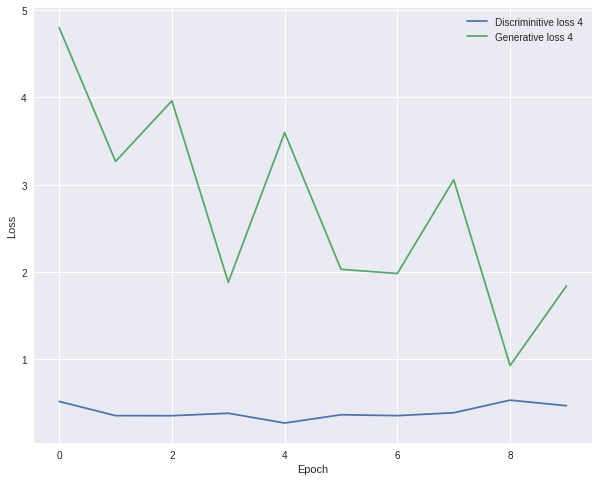

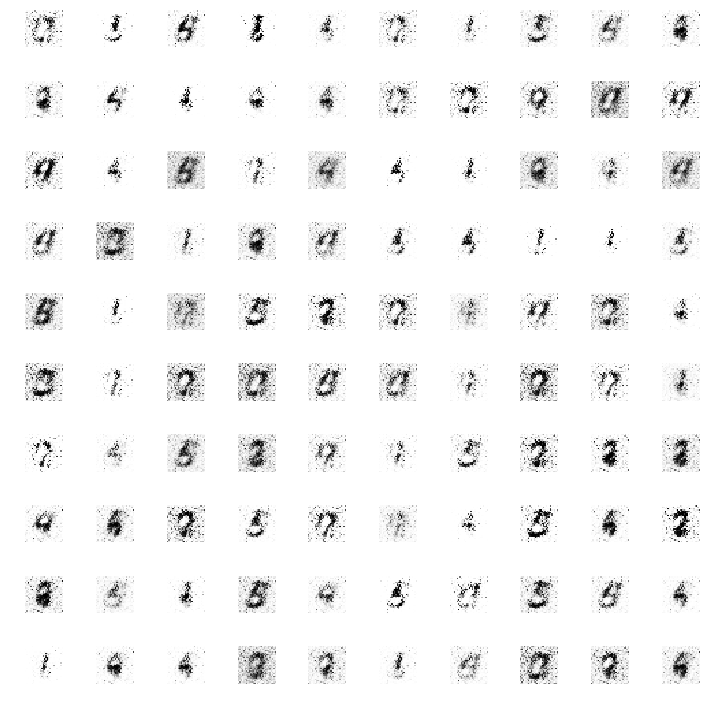

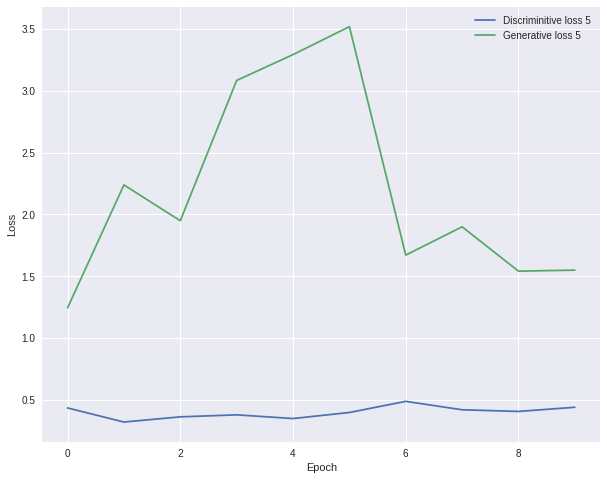

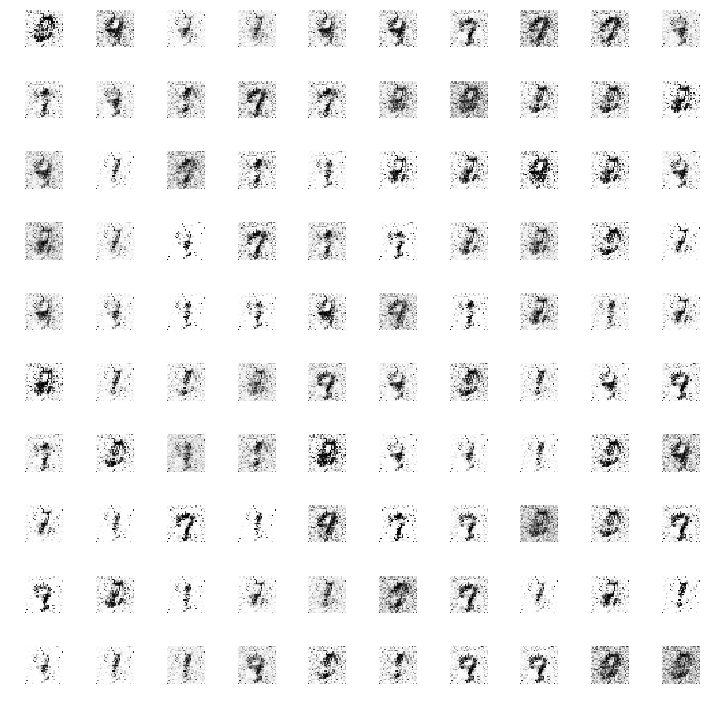

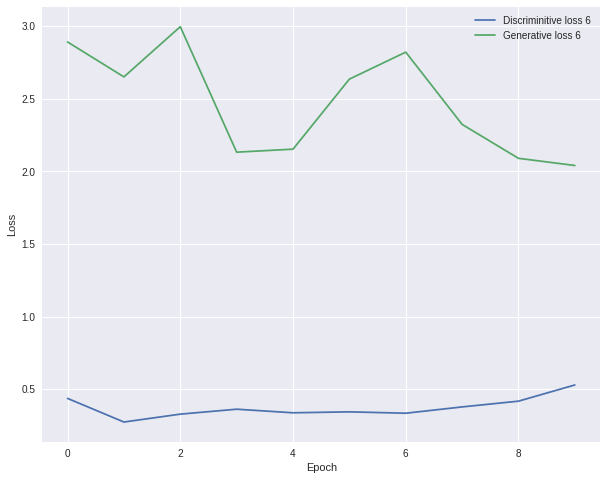

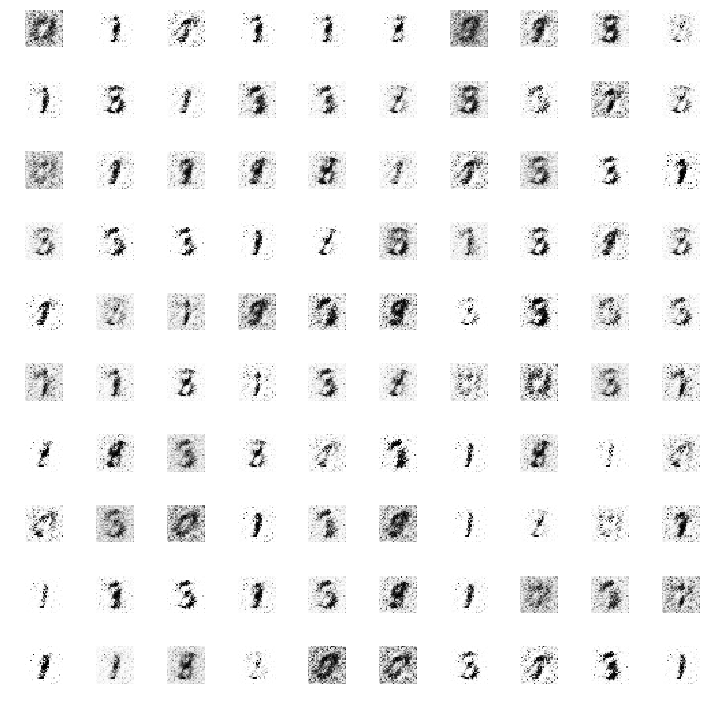

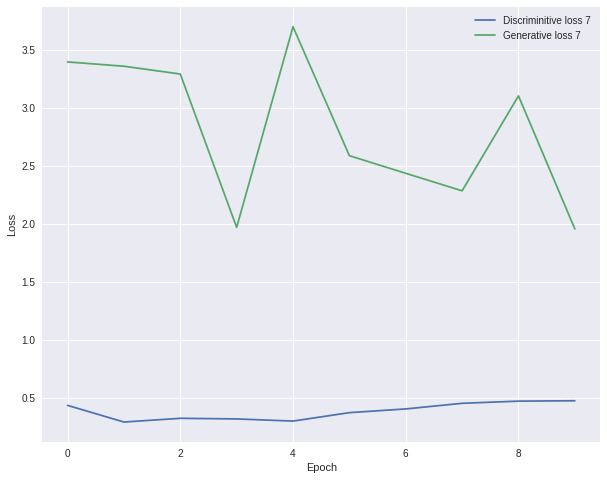

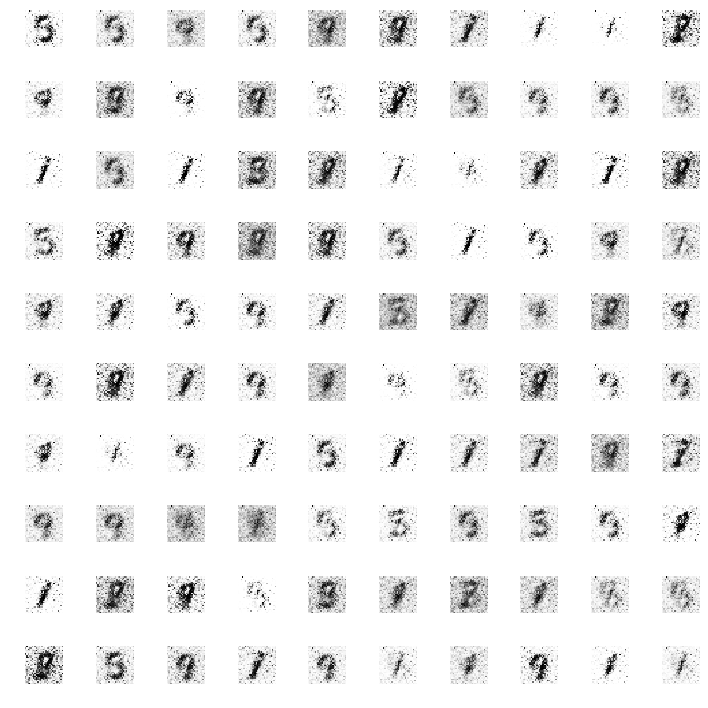

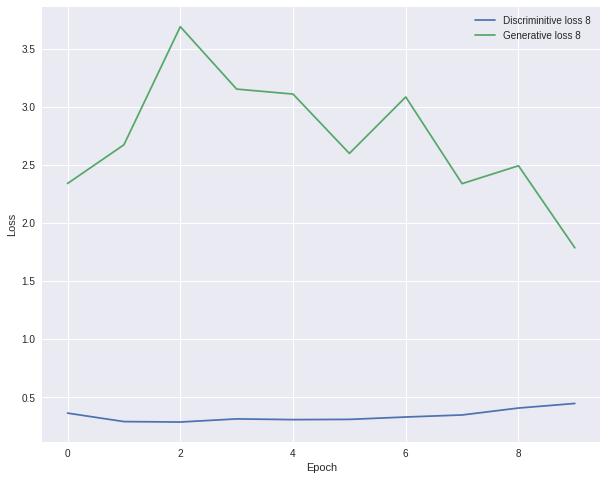

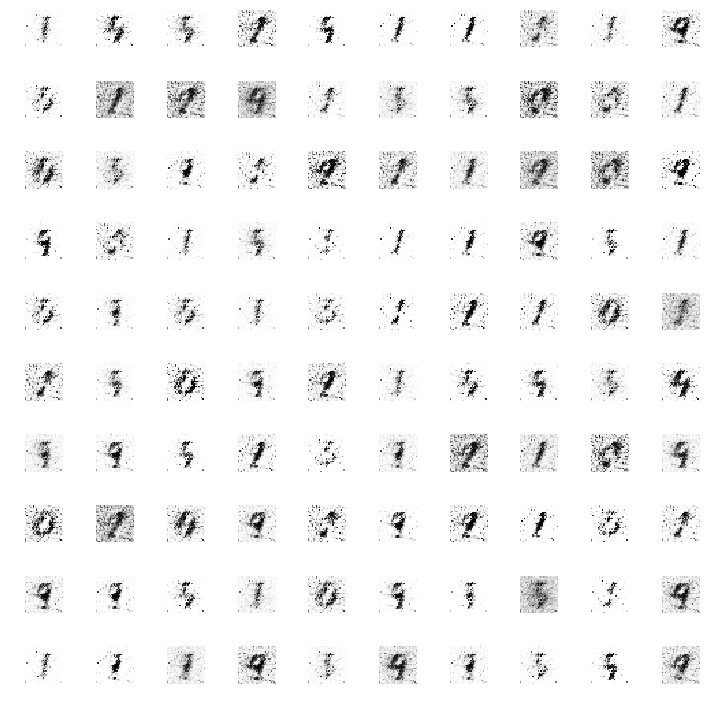

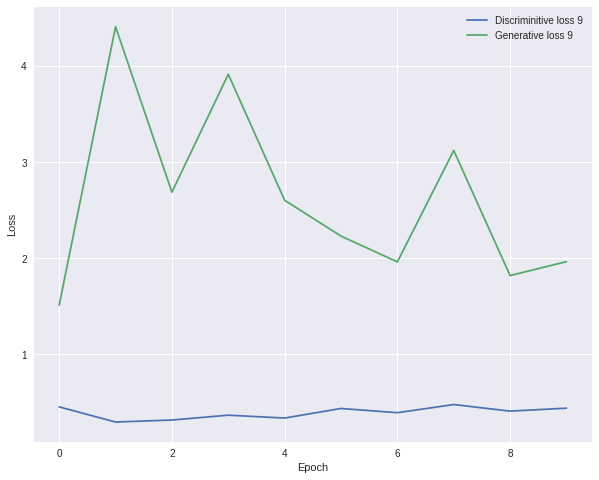

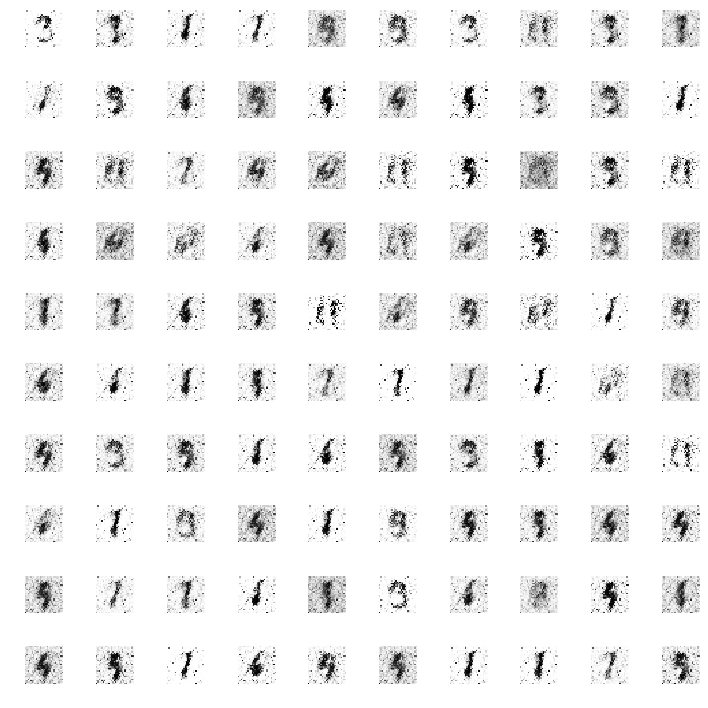

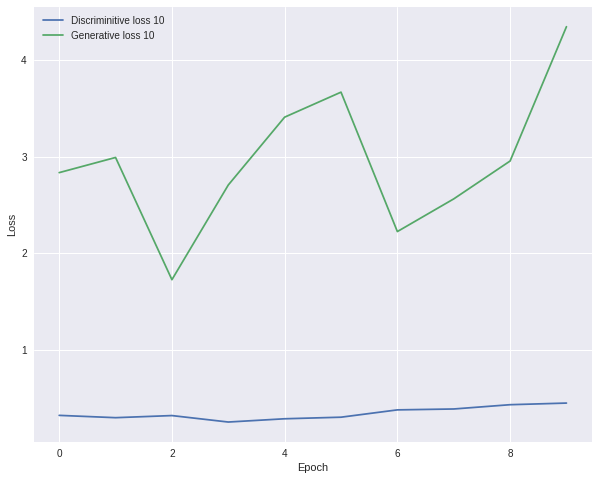

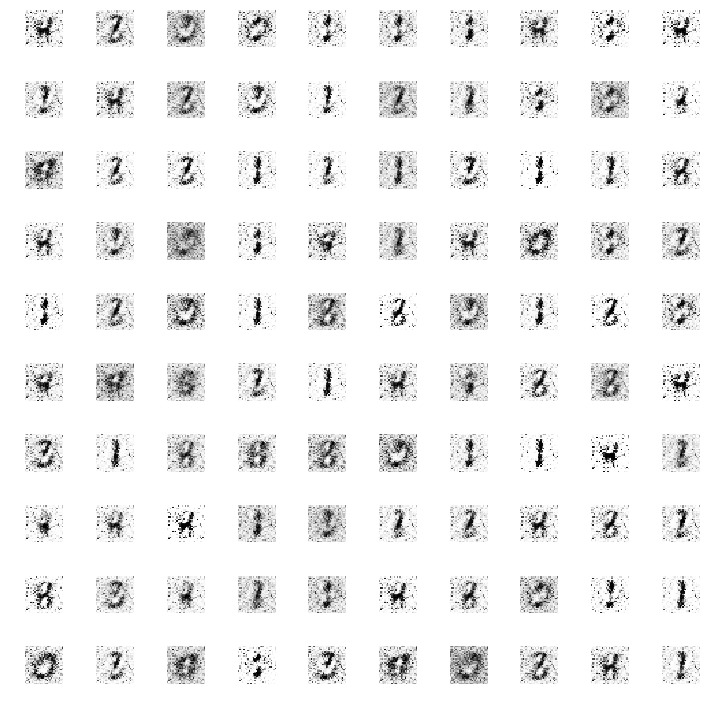

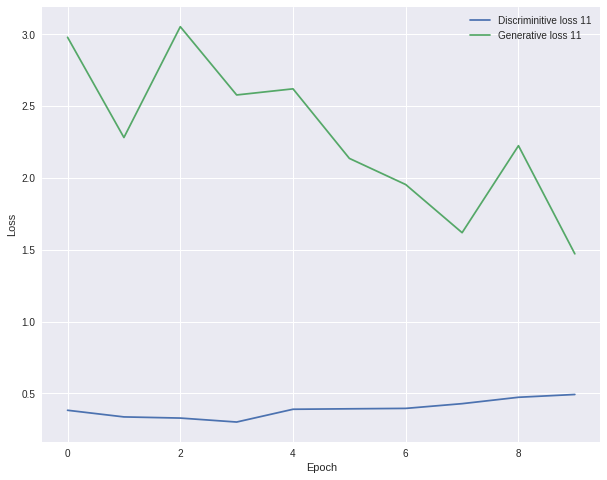

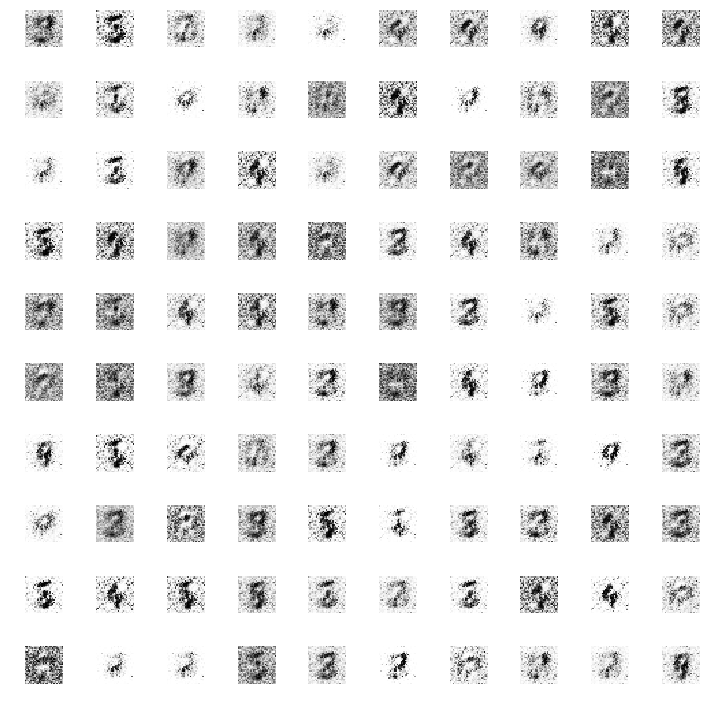

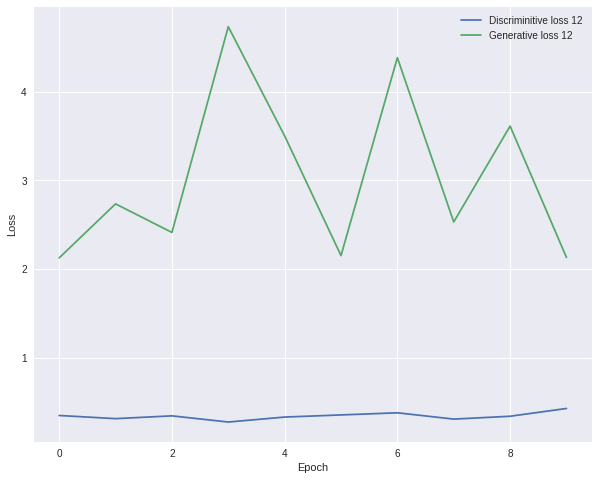

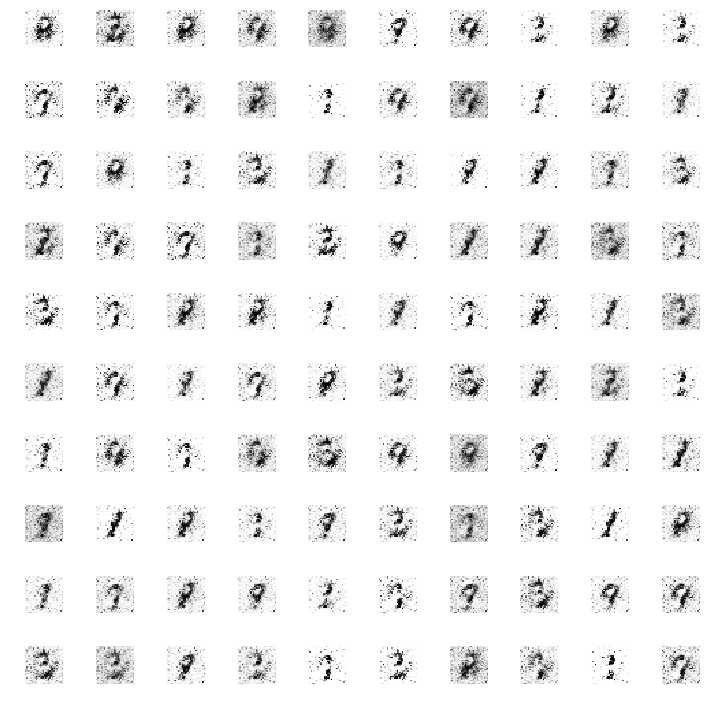

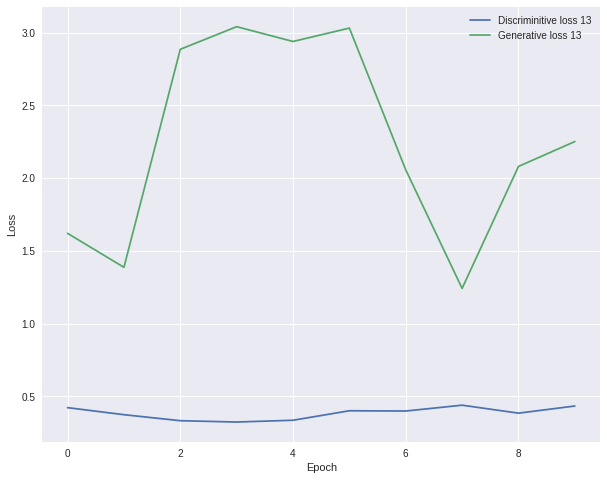

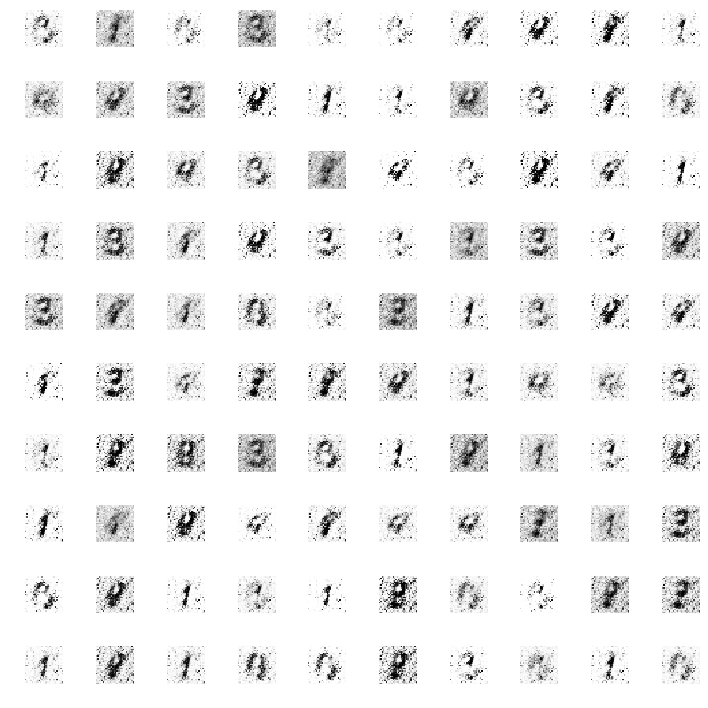

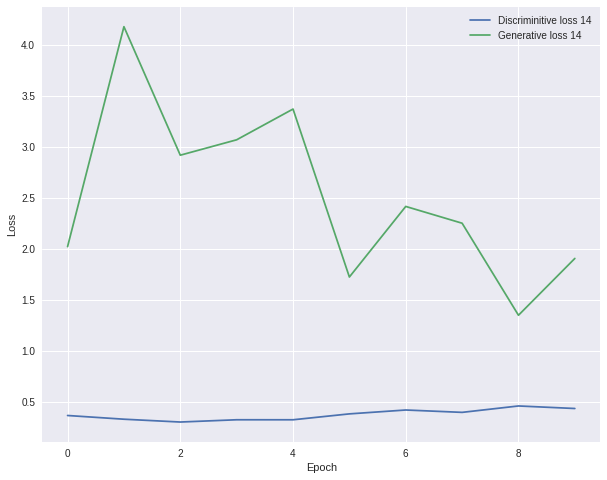

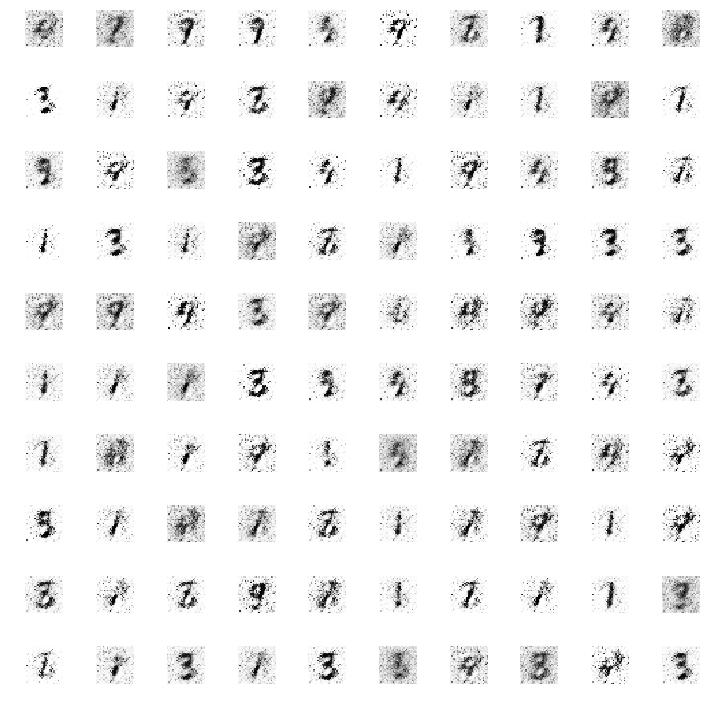

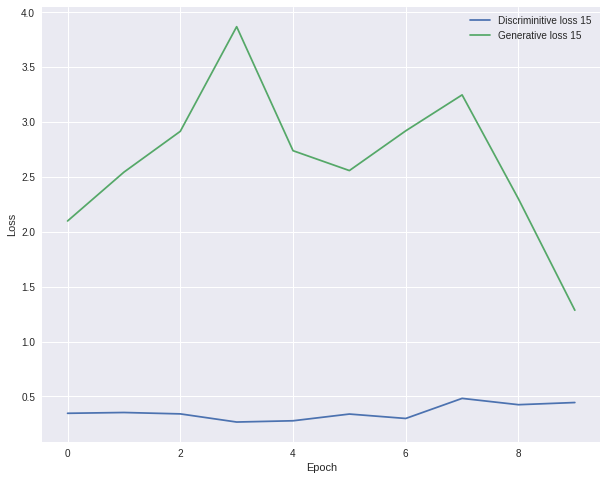

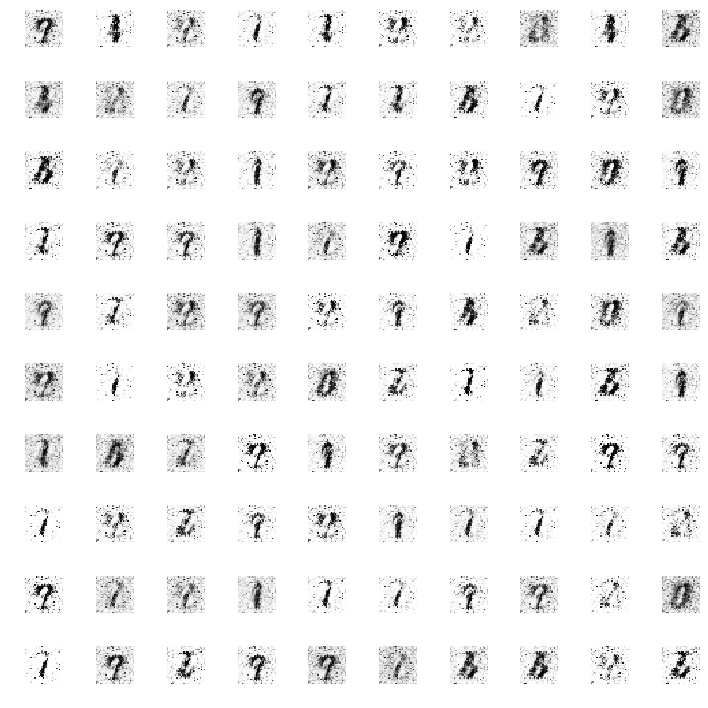

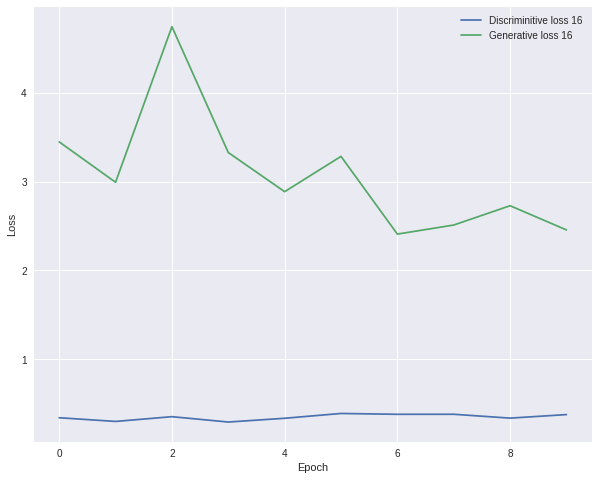

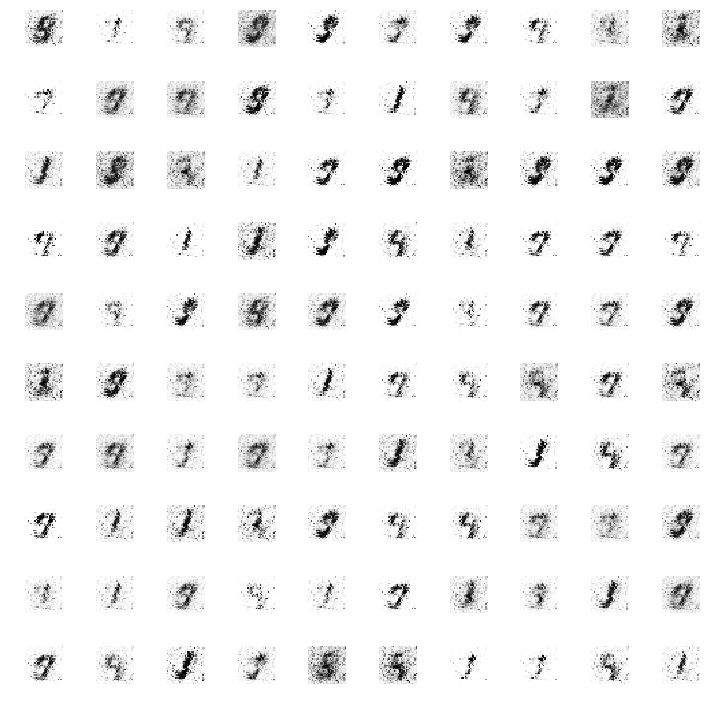

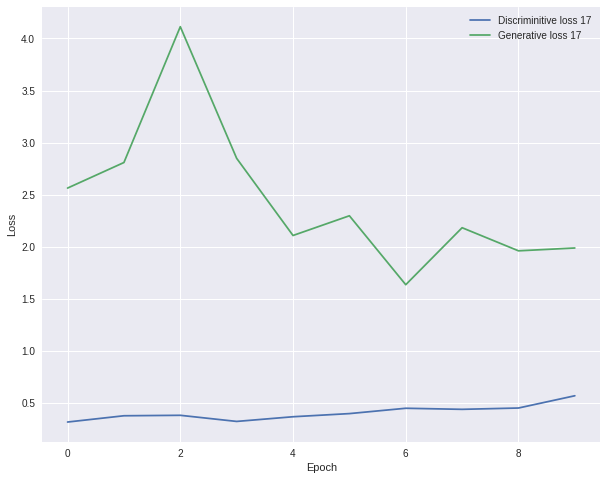

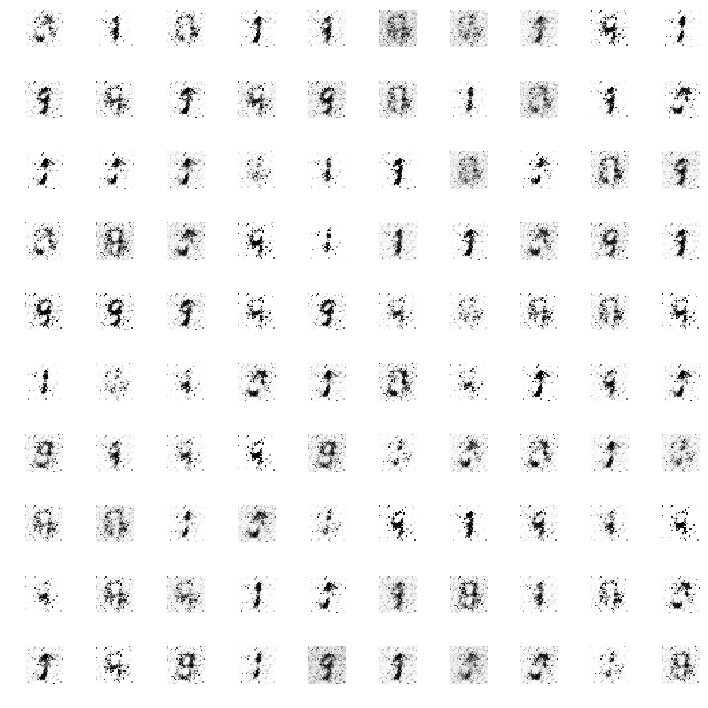

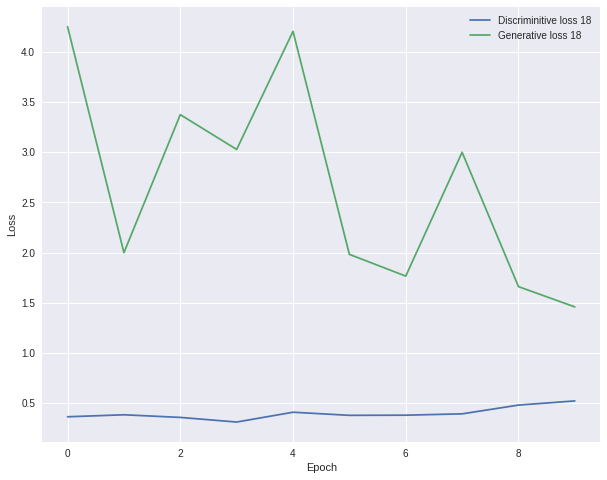

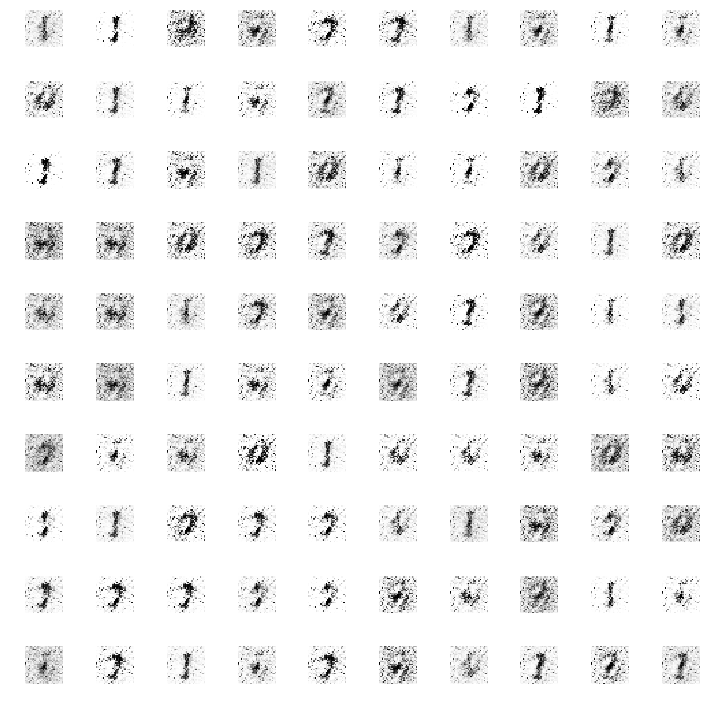

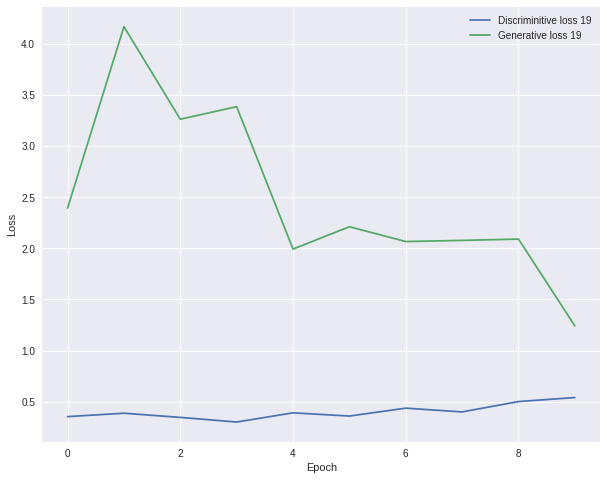

In [51]:
# Liste des Coûts des discriminateurs (un par epoch, dLoss[i] = coûts du discriminateur i)
dLosses = []

# Liste des Coûts des générateurs (un par epoch, gLoss[i] = coûts du générateur i)
gLosses = []

def train(epochs=1, batchSize=128):
  
    batchCount = X_train.shape[0] / batchSize
    
    # Affichage des paramètres de train
    print 'Epochs:', epochs
    print 'Batch size:', batchSize
    print 'Batches per epoch:', batchCount

    # ENTRAINEMENT
    
    # Pour chaque GAN
    for i in range(nb_GAN) :
      dLosses.append([])
      gLosses.append([])
    # Pour chaque epoch
      for e in xrange(1, epochs+1):

          # Affichage du numéro de l'epoch
          print '-'*15, 'Epoch %d' % e, '-'*15

          # Pour chaque batch
          for _ in tqdm(xrange(batchCount)):
              # On génère des données random de la bonne taille pour générer <batchSize> fausses images 
              noise = np.random.normal(0, 1, size=[batchSize, randomDim])
              imageBatch = X_train[np.random.randint(0, X_train.shape[0], size=batchSize)]

              # On génère des fausses images à partir du bruit généré
              generatedImages = generator[i].predict(noise)
              X = np.concatenate([imageBatch, generatedImages])

              # J'ai pas trop compris ça, j'admets
              yDis = np.zeros(2*batchSize)
              yDis[:batchSize] = 0.9

              # Entrainement du Discriminateur
              discriminator[i].trainable = True
              dloss = discriminator[i].train_on_batch(X, yDis)

              # Entrainement du Générateur, le Discriminateur étant immuable
              noise = np.random.normal(0, 1, size=[batchSize, randomDim])
              yGen = np.ones(batchSize)
              discriminator[i].trainable = False
              gloss = gan[i].train_on_batch(noise, yGen)

          # Enregistrement des Coûts pour cette epoch
          dLosses[i].append(dloss)
          gLosses[i].append(gloss)

          # On enregistre les données relatives à l'entrainement régulièrement
          if e == 1 or e % 20 == 0:
              plotGeneratedImages(e,i)
              saveModels(e,i)

      # Affichage des coûts en fonction de l'epoch
      plotLoss(e,i)
    
iterations = 10
batchSize = 128

# C'est parti !
train(iterations, batchSize)

# Téléchargements

In [52]:
from google.colab import files


for i in range(nb_GAN) :
  for e in xrange(1, 300+1):
      if e == 1 or e % 20 == 0:
          files.download('gan_generated_image_%d_epoch_%d.png' %(i,e))
          files.download('gan_generator_%d_epoch_%d.h5' %(i,e))
          files.download('gan_discriminator_%d_epoch_%d.h5' %(i,e))

MessageError: ignored